# Final Project: Predicting Newsletter Subscription Using Age and Play Time
### Group Members: Ashley Yen (39921549), Luka Ryvkin (37161692), Cayley Dawson (73184137), Saahij Gill (96977616)
### Date: December 6th, 2025
#### Github Repository Link: https://github.com/ashleyy6/DSCI-100-Plaicraft-Project/tree/main

## 1) Introduction 

Understanding what drives players to subscribe to game-related newsletters is essential for gaming studios and their marketing teams as they aim to build lasting connections with their audiences. Newsletter subscriptions provide a direct communication channel, enabling companies to share game updates, release announcements, and promotional content without relying on external platforms. By identifying the player characteristics associated with a higher likelihood of subscribing, studios can refine their outreach strategies, personalize their messaging, and ultimately foster stronger, long-term engagement within their player communities.



### i) The Central Question Explored in this Project - Broken into Two Components:

#### **Broad Question:** 

What player characteristics and behaviours are most predictive of subscribing to a game‑related newsletter, and how do these features differ between different player types?

_(For this report, we narrow the focus to two easily measurable attributes available in the dataset, which are age and hours played)._

#### **Specific Question:** 

Can age and total hours played predict whether a player is subscribed to the newsletter in the players dataset?

### ii) Dataset Description

The analysis uses the **players dataset**, which contains anonymized information about in‑game behaviours and demographics. The variables relevant to this report include:

1. **age**: The player's age in years (numeric).
2. **hours_played**: Total hours spent playing the game (numeric).
3. **subscribed**: Whether the player is subscribed to the game newsletter (binary).

These variables allow us to evaluate whether basic demographic and engagement features can predict a player’s likelihood of subscribing. The dataset is also appropriate for this question because it links individual characteristics to the outcome of interest, making it suitable for both exploratory and predictive analysis. Lastly, this dataset allows us to examine whether simple behavioural and demographic variables can provide meaningful predictive power when determining newsletter subscription tendencies.

## 2) Methods and Results

First, we will load in some libraries to help us code. 

In [189]:
library(tidyverse)
library(repr)
library(tidymodels)

Then, we will load in our data from our GitHub repository. We only need to read in the players.csv dataset, since the sessions.csv dataset is unnecessary in answering our question. We will also use the head() and tail() functions to give us an idea of what our dataset looks like. 

In [190]:
# load data 
players_data <- read.csv("https://raw.githubusercontent.com/ashleyy6/DSCI-100-Plaicraft-Project/refs/heads/main/players.csv")
head(players_data)
tail(players_data)

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
191,Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0.0,Rhys,Male,20
192,Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
193,Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
194,Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
195,Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
196,Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Next, we will perform some minimal tidying, just to select the columns that we need for our analysis, as well as filtering out any rows where one of the variables is missing an observation. 

In [191]:
## wrangle/clean data to the format necessary for planned analysis 

players_clean <- players_data |> 
    mutate(age = Age, subscribe = as_factor(subscribe)) |>       
    select(subscribe, played_hours, age) |>  
    filter(!is.na(subscribe), !is.na(played_hours), !is.na(age))  

head(players_clean)
tail(players_clean)

,subscribe,played_hours,age
,<fct>,<dbl>,<int>
1,TRUE,30.3,9
2,TRUE,3.8,17
3,FALSE,0.0,17
4,TRUE,0.7,21
5,TRUE,0.1,21
6,TRUE,0.0,17


,subscribe,played_hours,age
,<fct>,<dbl>,<int>
189,FALSE,0.0,17
190,TRUE,0.0,20
191,TRUE,0.0,17
192,FALSE,0.3,22
193,FALSE,0.0,57
194,FALSE,2.3,17


Next, we will create a scatterplot of the played hours vs age of the players, with the points colored by whether the player is subscribed or not. This will give us a first look at our data before we get into the analysis. 

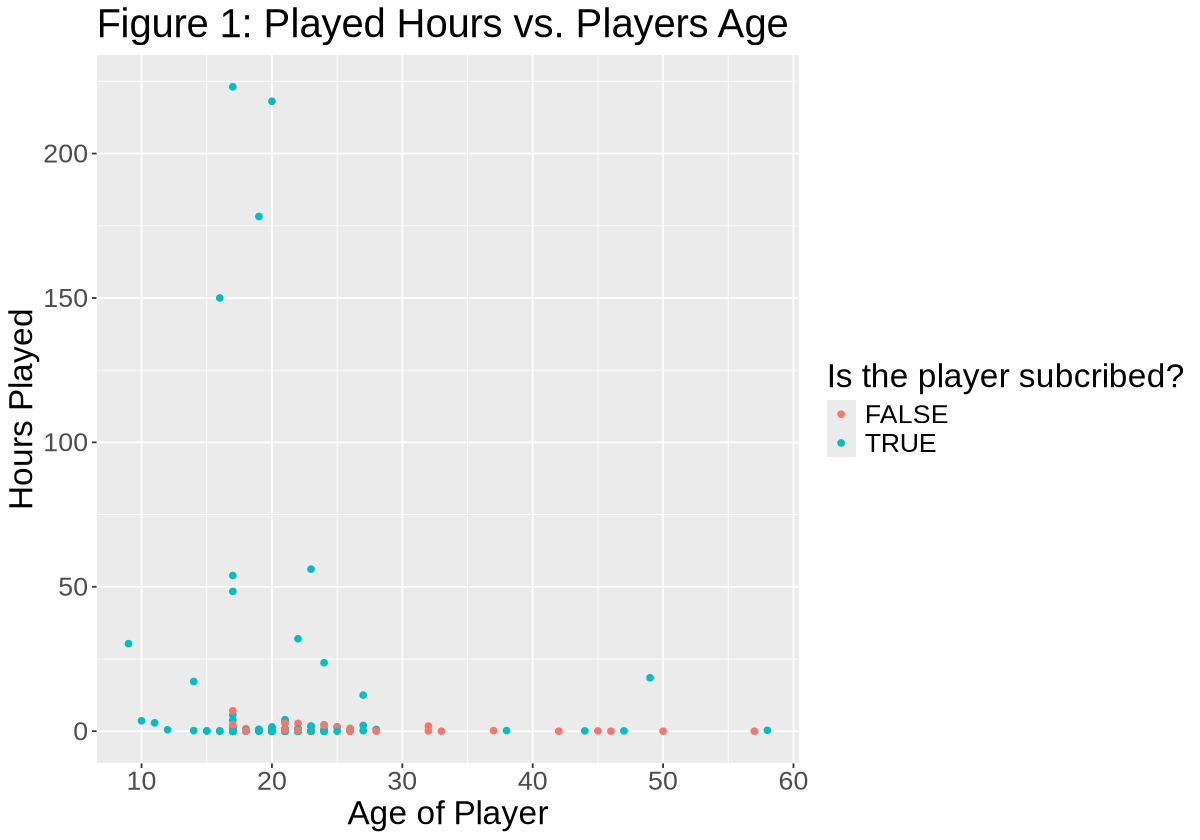

In [210]:
# primary/exploratory visualization 

options(repr.plot.width = 10, repr.plot.height = 7)

basic_players_plot <- ggplot(players_clean, aes(x = age, y = played_hours, color = subscribe)) + 
    geom_point() + 
    labs(x = "Age of Player", y = "Hours Played", color = "Is the player subcribed?") + 
    ggtitle("Figure 1: Played Hours vs. Players Age") + 
    theme(text = element_text(size = 20))
basic_players_plot

From the graph above, there's no obvious correlation between the age of the player and the hours played, nor do they seem to predict whether a person will be subscribed or not. However, in order to find the true answer, we should create a classification model in order to see if subscription values can be predicted from these two variables. 

Before we do that, let's take a look at how many people are subscribed vs not, and take a look at some summary statistics. 

In [211]:
# see how many people are subbed vs not 
players_proportions <- players_clean |> 
    group_by(subscribe) |>
    summarize(count = n(),
              percentage = n() / nrow(players_clean) * 100)
players_proportions

# see an overview of all players 
overall_summary <- players_clean |>
  summarize(
    n_players    = n(),
    mean_age     = round(mean(age), 2),
    sd_age       = round(sd(age), 2),
    mean_hours   = round(mean(played_hours), 2),
    sd_hours     = round(sd(played_hours), 2)
    )
overall_summary

# see the same overview as above, but separated by whether they are subscribed or not
by_sub_summary <- players_clean |>
  group_by(subscribe) |>
  summarize(
    n_players  = n(),
    mean_age   = round(mean(age), 2),
    sd_age     = round(sd(age), 2),
    mean_hours = round(mean(played_hours), 2),
    sd_hours   = round(sd(played_hours), 2)
    )
by_sub_summary

subscribe,count,percentage
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


n_players,mean_age,sd_age,mean_hours,sd_hours
<int>,<dbl>,<dbl>,<dbl>,<dbl>
194,21.14,7.39,5.9,28.5


subscribe,n_players,mean_age,sd_age,mean_hours,sd_hours
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,52,23.75,9.38,0.50,1.19
TRUE,142,20.18,6.28,7.88,33.11


From these summary statistics, we can see that around 27% of our dataset consists of people who are subscribed, and the other 73% consists of people who are not. We can also see the average age and hours played of all players, as well as those of the players who are subscribed and who are not. From these summary statistics, we can gather that while there is a significant difference in play time between players who are subscribed and those who are not, there does not appear to be a significant difference in age between players who are subscribed and who are not. This will give us the idea that we may end up finding no relationship between a player's age and their play time to gauge whether they will have a subscription or not. However, we will continue to perform more analysis to see if we can find a way to accurately predict subscription based on age and play time. 

We will create a knn-classification model to see if we can predict if a player has a subscription. First, we must split the data. 

In [212]:
set.seed(2020)

players_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

In [213]:
split_proportions <- players_train |> 
    group_by(subscribe) |>
    summarize(count = n(),
              percentage = n() / nrow(players_train) * 100)
split_proportions
players_proportions

subscribe,count,percentage
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


subscribe,count,percentage
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


We can see that the proportions of the actual data and the training data are very similar, which means that our model will be trained on data that reflects the real/full dataset. 

Next, we will create our recipe and tune our model to figure out what k-value works best for our data. 

In [214]:
players_recipe <- recipe(subscribe ~ age + played_hours, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
players_recipe

players_vfold <- vfold_cv(players_train, v = 10, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 2))

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics()
head(knn_results)



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5109890,10,0.04312959,Preprocessor1_Model01
1,roc_auc,binary,0.5170455,10,0.04782368,Preprocessor1_Model01
3,accuracy,binary,0.5582051,10,0.04711130,Preprocessor1_Model02
3,roc_auc,binary,0.5776894,10,0.06356870,Preprocessor1_Model02
5,accuracy,binary,0.6165201,10,0.04629029,Preprocessor1_Model03
5,roc_auc,binary,0.5753030,10,0.06723427,Preprocessor1_Model03


From here, we will find and compare the accuracies of our different k values in order to determine which k value works best for our model. 

[1] 15

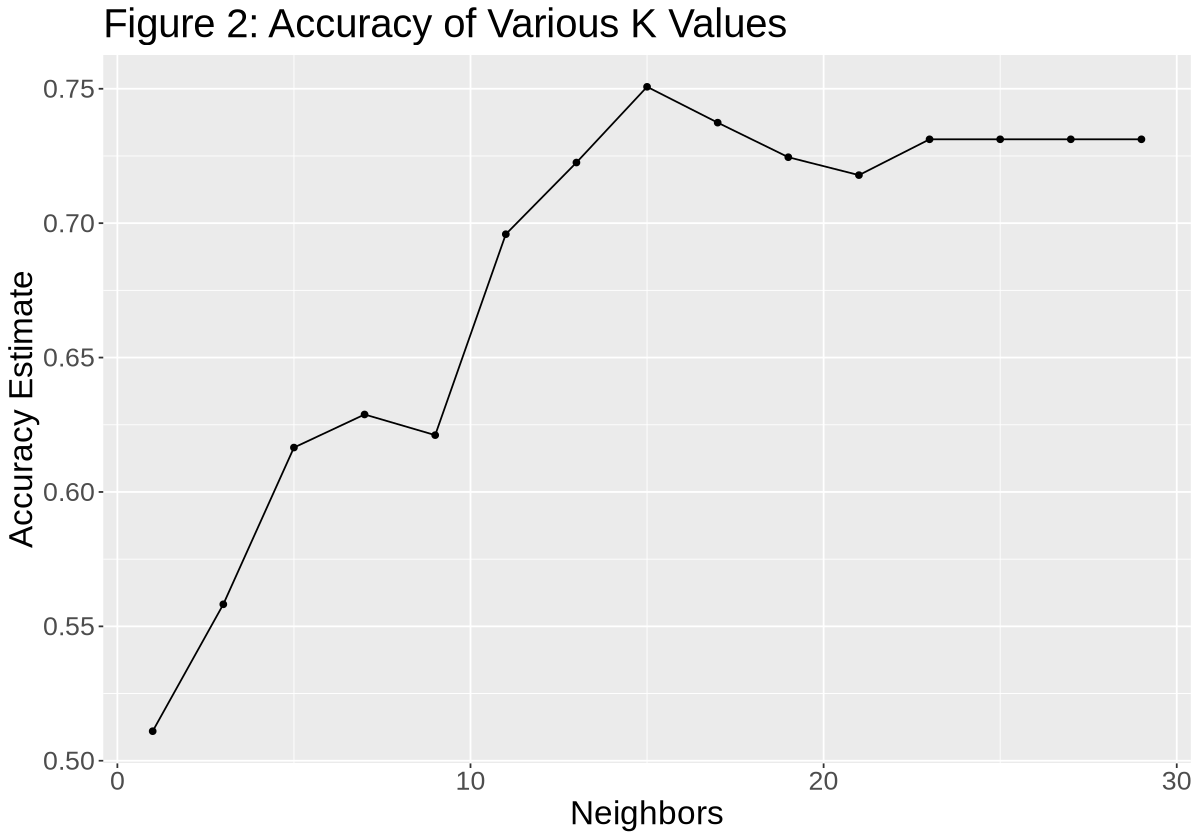

In [221]:
accuracies <- knn_results |> 
      filter(.metric == "accuracy")

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") + 
      ggtitle("Figure 2: Accuracy of Various K Values") + 
      theme(text = element_text(size = 20))
accuracy_versus_k

Having found the best k value, we will now create our final classification model with that value as our k. 

In [222]:
knn_best_k <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit_final <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_best_k) |>
  fit(data = players_train)

knn_fit_final

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(15,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2413793
Best kernel: rectangular
Best k: 15

Using our final trained model, we will predict the subscription of players based on our testing dataset. 

In [223]:
players_test_predictions <- predict(knn_fit_final, players_test) |>
  bind_cols(players_test)
head(players_test_predictions)
tail(players_test_predictions)

.pred_class,subscribe,played_hours,age
<fct>,<fct>,<dbl>,<int>
TRUE,TRUE,0.1,21
TRUE,TRUE,0.0,19
TRUE,TRUE,1.6,23
TRUE,TRUE,0.2,22
FALSE,TRUE,0.3,58
TRUE,TRUE,0.6,28


.pred_class,subscribe,played_hours,age
<fct>,<fct>,<dbl>,<int>
TRUE,FALSE,0.2,17
TRUE,FALSE,1.7,17
TRUE,FALSE,0.0,17
TRUE,FALSE,0.3,22
FALSE,FALSE,0.0,57
TRUE,FALSE,2.3,17


After making our predictions, we will create a bar plot to compare the predicted values of the model and actual values of the dataset. 

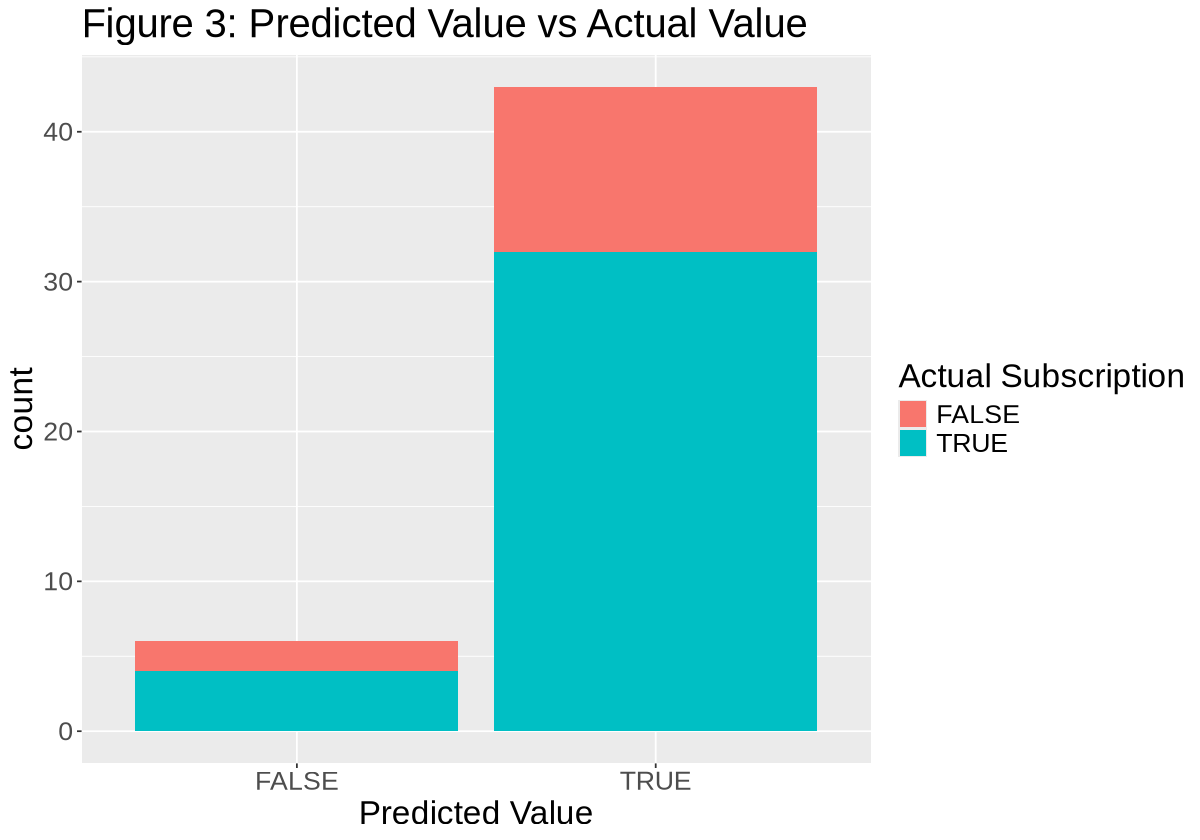

In [224]:
predictions_plot <- ggplot(players_test_predictions, aes(x = .pred_class, fill = subscribe)) + 
    geom_bar() + 
    labs(x = "Predicted Value", fill = "Actual Subscription") + 
    ggtitle("Figure 3: Predicted Value vs Actual Value") +
    theme(text = element_text(size = 20))
predictions_plot

We can also take a look at the confusion matrix in order to figure out the accuracy, precision, and recall of our model (which we can also find through code). 

In [225]:
player_accuracy <- players_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
player_accuracy

player_precision <- players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "first")
player_precision

player_recall <- players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "first")
player_recall

player_conf <- players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
player_conf

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.3333333


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.1538462


          Truth
Prediction FALSE TRUE
     FALSE     2    4
     TRUE     11   32

The accuracy of our model is approximately 69.39%, the precision of our model is approximately 33.33%, and the recall of our model is approximately 15.38%. None of these are particularily high values, and they confirm that player subscription cannot be predicted well based on a player's age and amount of hours played. 

## 3) Discussion 

### i) Summary of Findings

Age and total hours played turned out to be basically useless for predicting who subscribed to the newsletter. The scatter plot graph showed no relationship between age and playtime, and subscribers were scattered across all combinations of the two variables. Both groups had almost the same ages, and while subscribers played slightly more hours on average, the difference wasn’t consistent enough to matter. The KNN model confirmed the weak relationship. Even after testing different values of k, the accuracy flattened out around about 69%, and both precision and recall were low, especially for true positives.

### ii) Whether This Matched Expectations

Yes, the results aligned with expectations. Newsletter subscription is likely driven by other factors like psychological and behavioural factors, stuff like interest, motivation, engagement habits, or exposure to marketing, not by simple demographics or raw playtime. The slight separation in hours played was too inconsistent to be useful, and age contributed nothing, which is what you’d expect given the nature of the behaviour.

### iii) Impact of These Findings

The takeaway is that age and total playtime don’t really help when trying to predict who will subscribe to a newsletter. Using them for marketing or segmentation would be ineffective. To make a useful prediction, you would need better data, like which events players join, what they buy, how often they log in, or how they interact with past promotions. Without that, any model will be pretty weak.

### iv) Future Questions Raised

- Which behavioural features genuinely influence subscription likelihood?
- Are socially active players (guilds, chat, events) more likely to subscribe?
- Does store interaction or spending correlate with higher subscription rates?
- Do time based patterns, session frequency, streaks, or session length predict engagement?
- Does experience level (which wasn’t included), provide stronger predictive signal?